# Inter-annotator agreement between the first 10 annotators of WS-353
Measured in Kappa and Rho

In [14]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from skll.metrics import kappa
from scipy.stats import spearmanr
from itertools import combinations

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


In [2]:
df1 = pd.read_csv('../thesisgenerator/similarity-data/wordsim353/set1.csv')
df2 = pd.read_csv('../thesisgenerator/similarity-data/wordsim353/set2.csv')
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,1,10,11,12,13,14,15,16,2,3,4,5,6,7,8,9,Human (mean),Word 1,Word 2
0,9,2,6,7,8,NaN,NaN,NaN,6,8,8,7,8,8.0,4,7,6.77,love,sex
1,9,9,7,5,7,NaN,NaN,NaN,7,8,7,8,9,8.5,5,6,7.35,tiger,cat
2,10,10,10,10,10,NaN,NaN,NaN,10,10,10,10,10,10.0,10,10,10.00,tiger,tiger
3,8,8,9,4,9,NaN,NaN,NaN,8,7,7,8,9,7.0,6,7,7.46,book,paper
4,8,8,10,3,9,NaN,NaN,NaN,7,9,9,8,8,7.0,7,6,7.62,computer,keyboard


In [4]:
def bin(arr, nbins=2):
    bins = np.linspace(arr.min(), arr.max(), nbins+1)
    return np.digitize(arr, bins[1:-1])

In [5]:
bin(df['1'], nbins=5)

array([4, 4, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 1, 2, 3, 1, 0,
       0, 2, 3, 3, 1, 3, 3, 4, 4, 0, 0, 4, 3, 3, 4, 4, 1, 4, 4, 4, 3, 3, 1,
       3, 3, 1, 4, 4, 3, 3, 3, 4, 3, 2, 3, 4, 4, 3, 1, 3, 3, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 3, 2, 1, 2, 1, 2, 1,
       1, 1, 0, 0, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 1, 4, 4, 4, 4, 3, 3, 3, 3,
       4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 3,
       3, 2, 4, 4, 3, 0, 3, 3, 1, 4, 3, 1, 4, 4, 4, 0, 3, 3, 3, 3, 3, 4, 2,
       0, 3, 4, 4, 3, 3, 3, 1, 1, 4, 2, 2, 3, 2, 3, 3, 3, 3, 2, 0, 3, 2, 3,
       2, 0, 3, 3, 2, 2, 3, 3, 3, 4, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 2, 2, 1,
       1, 4, 4, 2, 0, 1, 3, 4, 0, 2, 2, 1, 3, 2, 2, 2, 3, 3, 3, 2, 0, 2, 3,
       3, 3, 3, 3, 2, 1, 4, 3, 3, 3, 3, 3, 3, 0, 3, 4, 2, 2, 1, 0, 3, 0, 2,
       2, 2, 2, 3, 4, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 4, 4, 3, 3, 2, 3, 2, 2, 1, 2, 4, 3, 2,
       3, 3,

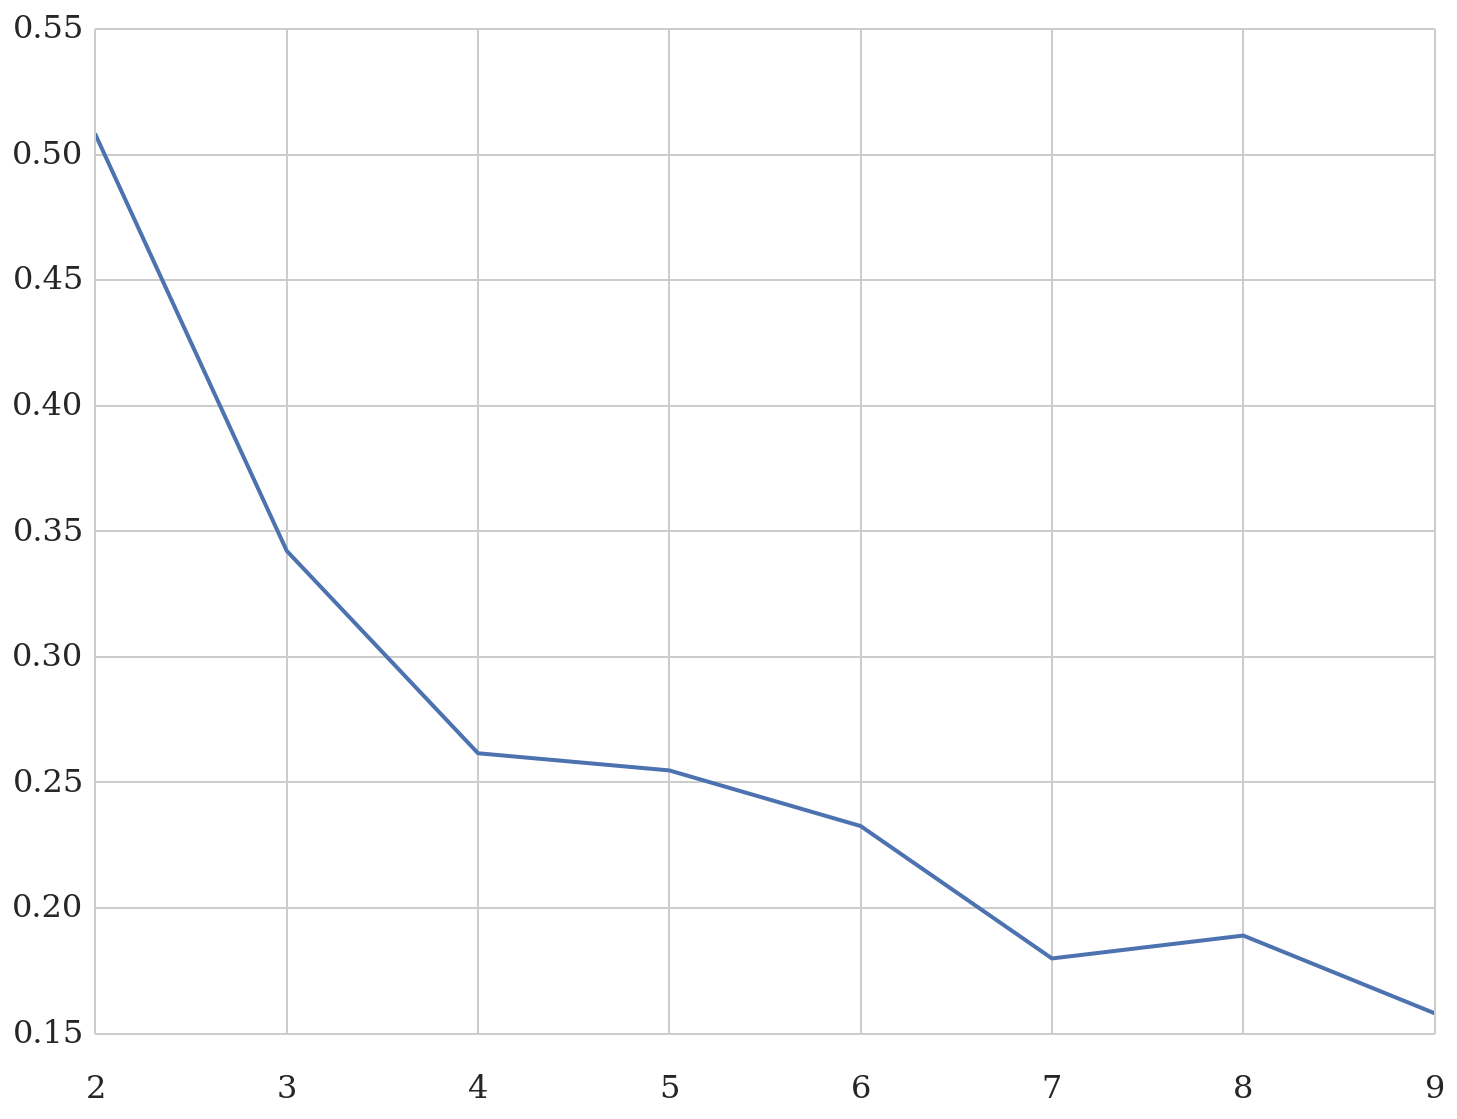

In [6]:
bin_counts = [2,3,4,5,6,7,8,9]
kappas = [kappa(bin(df['1'], b), 
                bin(df['2'], b)) for b in bin_counts]
plt.plot(bin_counts, kappas)

In [35]:
# pair, bin count, kappa
kappas = []
for name1, name2 in combinations('123456789', 2):
    for b in bin_counts:
        kappas.append([name1+'_'+name2, 
                       b, 
                       kappa(bin(df[name1], b), bin(df[name2], b))])


In [36]:
kappas = pd.DataFrame(kappas, columns=['pair', 'bins', 'kappa'])
kappas.head(3)

,pair,bins,kappa
0,1_2,2,0.508072
1,1_2,3,0.342261
2,1_2,4,0.261647


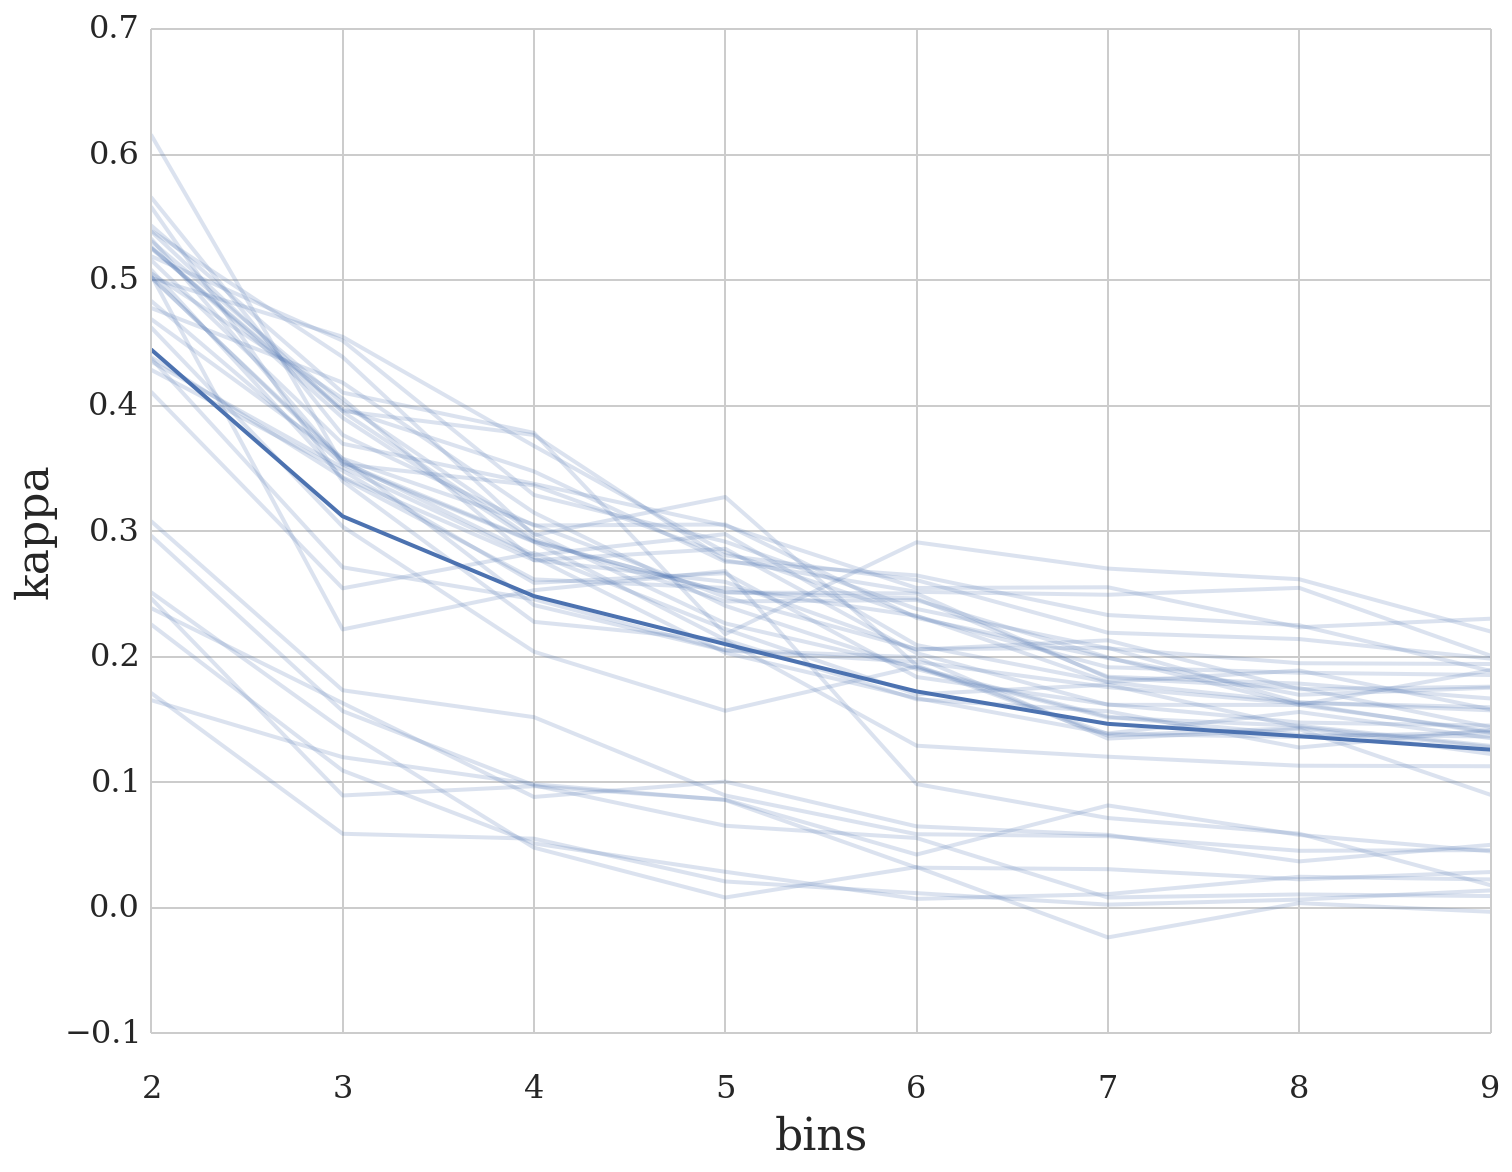

In [37]:
sns.tsplot(kappas, time='bins', unit='pair', value='kappa', err_style='unit_traces');

In [38]:
rhos = []
for name1, name2 in combinations('123456789', 2):
    rhos.append(spearmanr(bin(df[name1], b), bin(df[name2], b))[0])

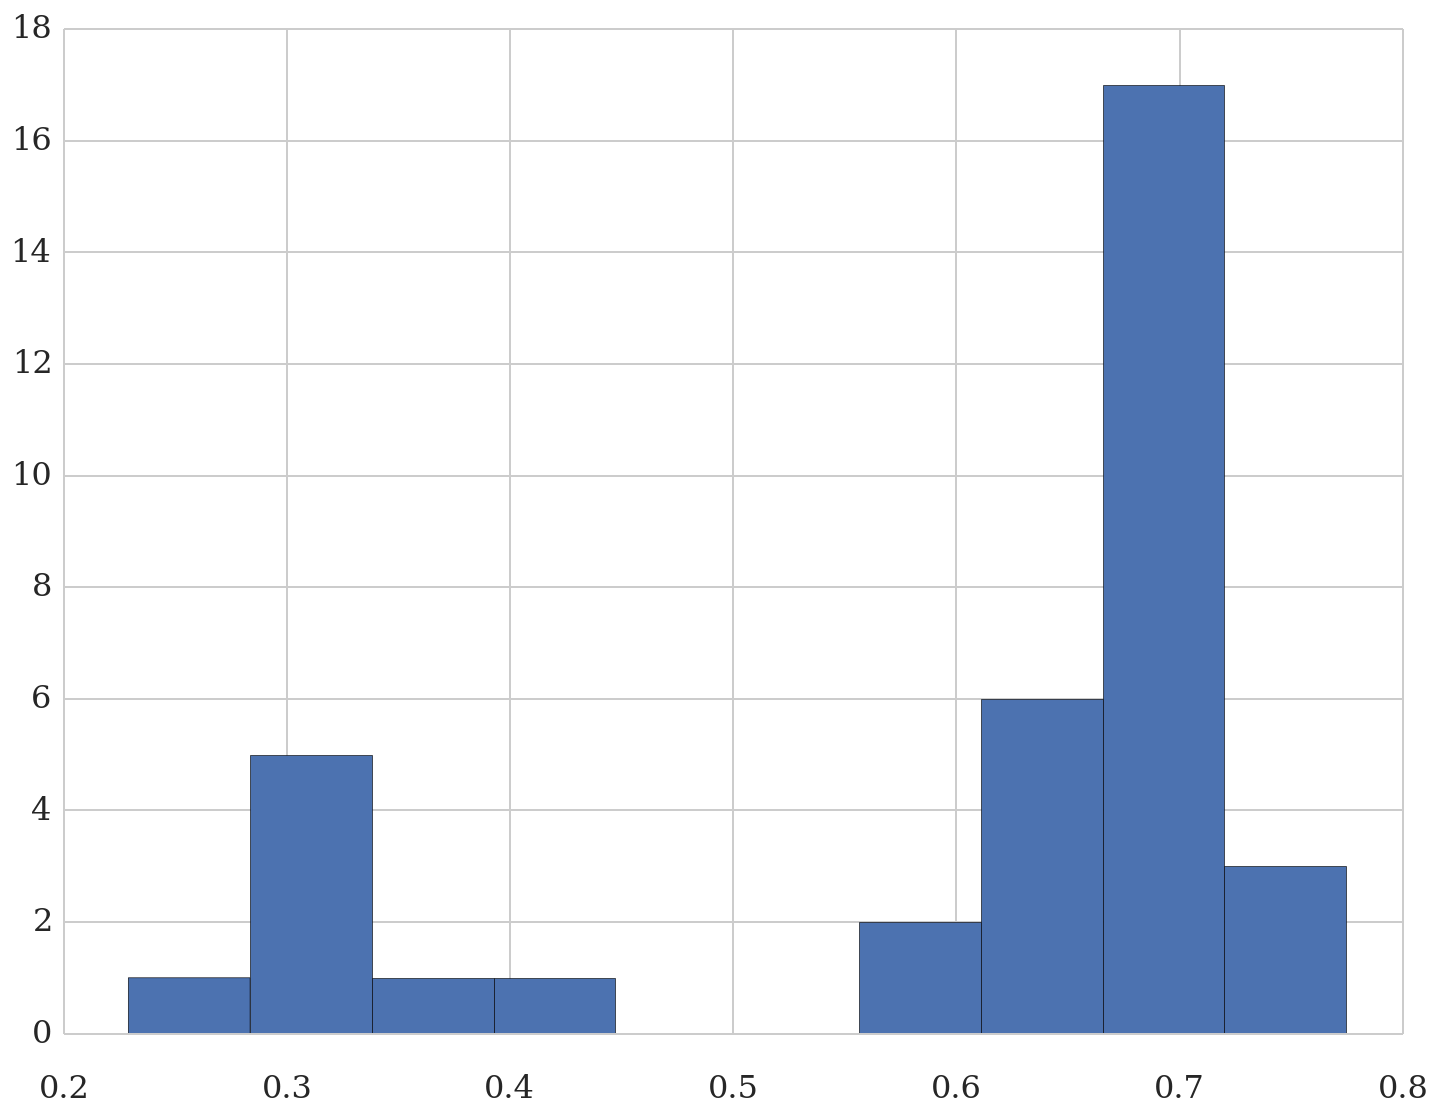

In [39]:
plt.hist(rhos);